In [2]:
import glob
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
#import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2024-09-25 04:17:59.983838: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 04:18:00.082500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 04:18:00.082543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 04:18:00.095077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 04:18:00.124029: I tensorflow/core/platform/cpu_feature_guar

In [3]:
save_plots = False
plot_dir = '../plots/plots_2024-09-20'

## Load and prep emu

In [4]:
# need to modify this on hyperion
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load lib and p(k)s

In [5]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

#tag_params = '_p3_n500'
tag_params = '_p5_n10000'
tag_mocks = tag_params
tag_fields = '_deconvolved'
#dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'
#dir_mocks = f'/data/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[1,0,0,0]'
tag_pk = '_b1000'
tag_pk_zspace = '_b1000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()

# idxs_LH = np.sort([int(re.search(r'LH(\d+)', dir_mocks).group(1)) \
#         for dir_mocks in os.listdir(dir_mocks) \
#         if re.search(r'LH\d+', dir_mocks)])
# idxs_LH = np.sort([int(re.search(r'_(\d+)', dir_pks_zspace).group(1)) \
#         for dir_pks_zspace in os.listdir(dir_pks_zspace) \
#         if re.search(r'_\d+', dir_pks_zspace)])
#idxs_LH = list(params_df.index.values)
# this one gets only ones we've computed pk of (zspace, cuz probs have both if have zspace)
idxs_LH_all = np.array([int(re.search(r'pk_(\d+)\.npy', f).group(1)) for f in glob.glob(f'{dir_pks_zspace}/pk_*.npy')])
idxs_LH_all = np.sort(idxs_LH_all)
# limit to n_plot for now
n_plot = 100
#idxs_LH = idxs_LH_all[:n_plot]
rng = np.random.default_rng(42)
idxs_LH = rng.choice(idxs_LH_all, n_plot, replace=False)

idxs_LH = np.array(np.sort(idxs_LH))
n_lib = len(idxs_LH)

print(n_lib)

100


In [6]:
print(idxs_LH)

[ 132  200  213  239  262  272  283  287  303  386  399  437  474  499
  506  554  584  595  607  686  696  741  846  920  993 1048 1070 1131
 1168 1177 1180 1193 1258 1276 1322 1364 1382 1410 1415 1418 1429 1435
 1445 1530 1534 1565 1596 1650 1659 1697 1743 1824 1854 1871 1951 2174
 2203 2207 2225 2235 2348 2354 2385 2394 2417 2425 2453 2488 2489 2558
 2628 2636 2648 2660 2672 2676 2716 2722 2725 2726 2796 2850 2851 2874
 2893 2928 2932 2938 2962 2964 3069 3102 3259 3263 3302 3367 3579 3681
 3710 3733]


### Load data 

In [7]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(100, 30)


In [8]:
# overall quantities
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 100 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    param_dict.update(param_dict_fixed)
    cosmo_params_emu = utils.get_cosmo_emu(param_dict)
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)
print(Pk_emu.shape)

0
(100, 30)


In [9]:
expfactor = 1.0
kaiser_boosts = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 100 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    cosmo = utils.get_cosmo(param_dict)
    # kaiser boost only depends on k if neutrino mass is nonzero
    # for kaiser boost, the bias is the linear EULERIAN bias!
    # which is b1_eul = 1 + b1_lag
    bias_eulerian = 1 + bias_params[0]
    kaiser_boosts.append( cosmo.Kaiser_boost(expfactor, l=0, bias=bias_eulerian) )

0


In [10]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

In [11]:
print(np.min(kaiser_boosts), np.max(kaiser_boosts))

1.1570180795862053 1.2182820613737255


## Plot

/tmp/ipykernel_460778/495678036.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_460778/495678036.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_460778/495678036.py:46: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_460778/495678036.py:51: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7fd2d4235e10>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x7fd625366090>, <matplotlib.lines.Line2D object at 0x7fd2b416c890>] ['median', '16-84 percentile']


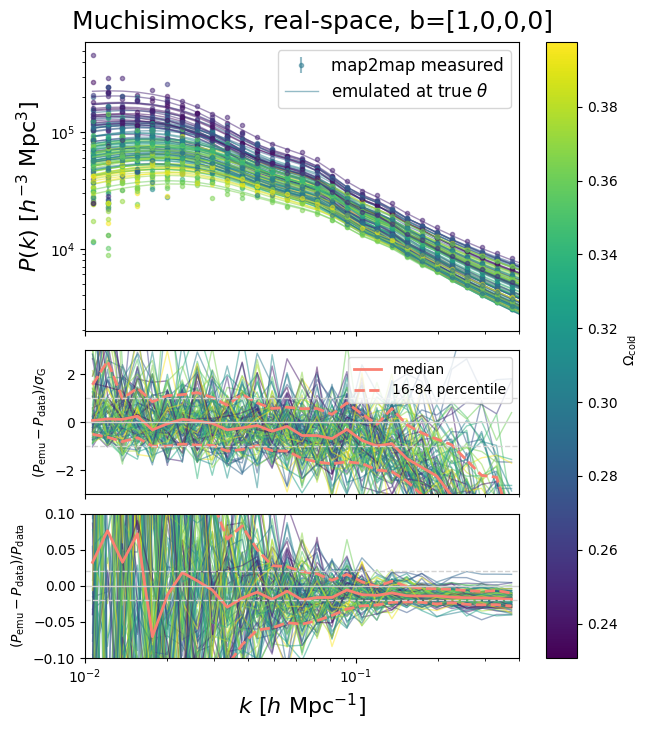

In [12]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
    #axarr[1].set_ylim(-10, 20)
    #axarr[2].set_ylim(-0.4, 0.4)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_460778/1192163480.py:46: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_460778/1192163480.py:47: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_460778/1192163480.py:57: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_460778/1192163480.py:67: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x7fd2905ba990>, <matplotlib.lines.Line2D object at 0x7fd290228250>, <matplotlib.lines.Line2D object at 0x7fd290229bd0>, <matplotlib.lines.Line2D object at 0x7fd29022a450>, <matplotlib.lines.Line2D object at 0x7fd290238810>, <matplotlib.lines.Line2D object at 0x7fd290239110>, <matplotlib.lines.Line2D object at 0x7fd29023b210>, <matplotlib.lines.Line2D object at 0x7fd29023bb50>, <matplotlib.lines.Line2D object at 0x7fd290249e10>, <matplotlib.lines.Line2D object at 0x7fd29024a6d0>, <matplotlib.lines.Line2D object at 0x7fd29025c9d0>, <matplotlib.lines.Line2D object at 0x7fd29025d2d0>, <matplotlib.lines.Line2D object at 0x7fd29025f310>, <matplotlib.lines.Line2D object at 0x7fd29025fb50>, <matplotlib.lines.Line2D object at 0x7fd290269cd0>, <matplotlib.lines.Line2D object at 0x7fd29026a5d0>, <matplotlib.lines.Line2D object at 0x7fd29027c790>, <matplotlib.lines.Line2D object at 0x7fd2906c2010>, <matplotlib.lines.Line2D object at 0x7fd29027e950>, <matplotlib

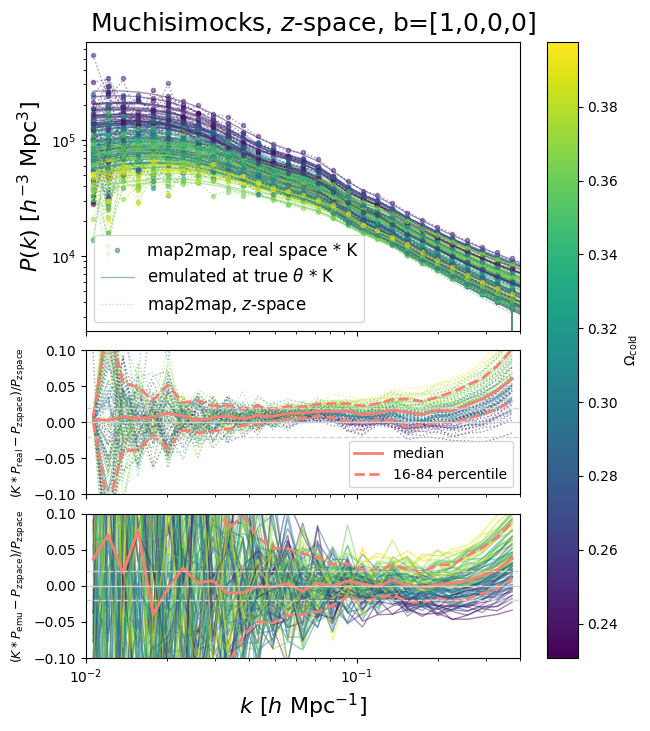

In [13]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_460778/2375682257.py:45: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_460778/2375682257.py:52: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7fd26c1ca490>, <matplotlib.lines.Line2D object at 0x7fd26c1ebad0>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x7fd26c12ca90>, <matplotlib.lines.Line2D object at 0x7fd24c55fc90>] ['median', '16-84 percentile']


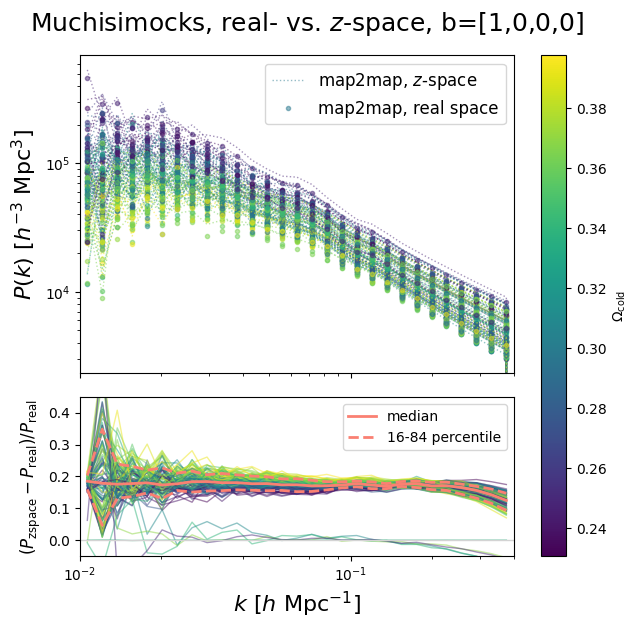

In [14]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.45)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')

In [17]:
ratios = []
for i, idx_LH in enumerate(idxs_LH):
    ratio = (Pk_zspace[i] - Pk[i])/Pk[i]
    ratios.append(ratio)

/tmp/ipykernel_460778/364526876.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = (Pk_zspace[i] - Pk[i])/Pk[i]


In [20]:
k

array([0.01065667, 0.01210222, 0.01374386, 0.01560817, 0.01772538,
       0.02012978, 0.02286032, 0.02596126, 0.02948284, 0.0334821 ,
       0.03802386, 0.04318169, 0.04903917, 0.05569119, 0.06324555,
       0.07182463, 0.08156745, 0.09263184, 0.1051971 , 0.11946679,
       0.13567213, 0.15407568, 0.17497562, 0.19871058, 0.22566512,
       0.25627597, 0.2910391 , 0.33051775, 0.37535157, 0.42626697])

In [22]:
ratios_k = np.array(ratios)[:,np.argmin(np.abs(k-0.1))]

(array([ 4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  5., 21.,
        23., 26.,  8.,  8.]),
 array([2.20158198e-05, 6.67908937e-03, 1.33361629e-02, 1.99932365e-02,
        2.66503100e-02, 3.33073836e-02, 3.99644571e-02, 4.66215307e-02,
        5.32786043e-02, 5.99356778e-02, 6.65927514e-02, 7.32498249e-02,
        7.99068985e-02, 8.65639720e-02, 9.32210456e-02, 9.98781191e-02,
        1.06535193e-01, 1.13192266e-01, 1.19849340e-01, 1.26506413e-01,
        1.33163487e-01, 1.39820560e-01, 1.46477634e-01, 1.53134708e-01,
        1.59791781e-01, 1.66448855e-01, 1.73105928e-01, 1.79763002e-01,
        1.86420075e-01, 1.93077149e-01, 1.99734222e-01]),
 <BarContainer object of 30 artists>)

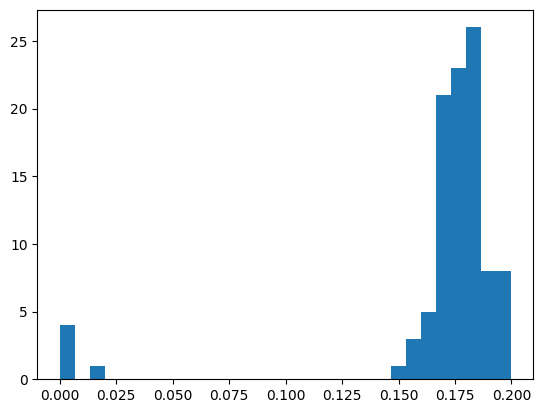

In [25]:
plt.hist(ratios_k, bins=30)

In [26]:
i_bad = ratios_k<0.05
idxs_LH_bad = idxs_LH[i_bad]
print(idxs_LH_bad)

[1596 2348 2394 3681 3710]


In [27]:
idx_LH = idxs_LH_bad[0]
dir_LH = f'{dir_mocks}/LH{idx_LH}'

fn_bfields_kcut_deconvolved = f'{dir_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
tag_zspace = '_zspace'
fn_bfields_zspace_kcut_deconvolved = f'{dir_LH}/bias_fields_eul{tag_zspace}_deconvolved_{idx_LH}.npy'
print(fn_bfields_kcut_deconvolved)
bias_terms_eul_pred_kcut_deconvolved = np.load(fn_bfields_kcut_deconvolved)
bias_terms_eul_pred_zspace_kcut_deconvolved = np.load(fn_bfields_zspace_kcut_deconvolved)

/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH1596/bias_fields_eul_deconvolved_1596.npy


-653.4196 2649.9841
-653.4196 2649.9841
(128, 128, 128)
(128, 128)


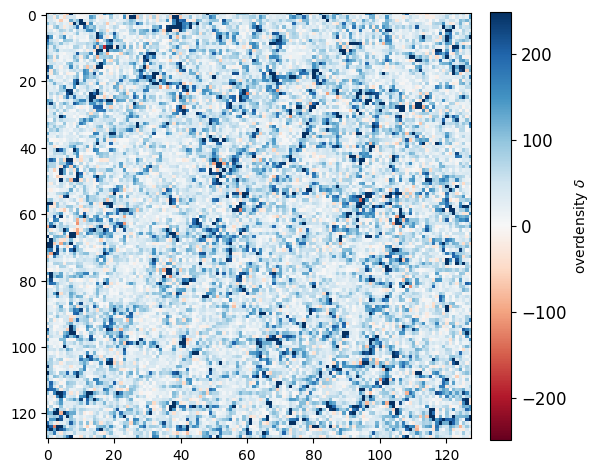

In [29]:
plotter.plot_field(bias_terms_eul_pred_kcut_deconvolved[0])

-498.2393 2744.3528
-498.2393 2744.3528
(128, 128, 128)
(128, 128)


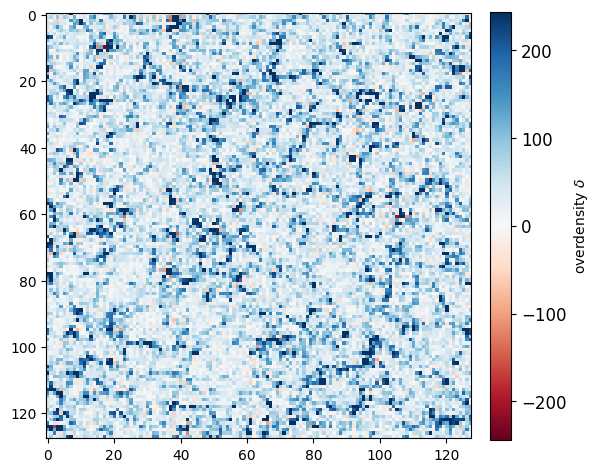

In [32]:
plotter.plot_field(bias_terms_eul_pred_zspace_kcut_deconvolved[0])

-880620.6 187016.19
-880620.6 187016.19
(128, 128, 128)
(128, 128)


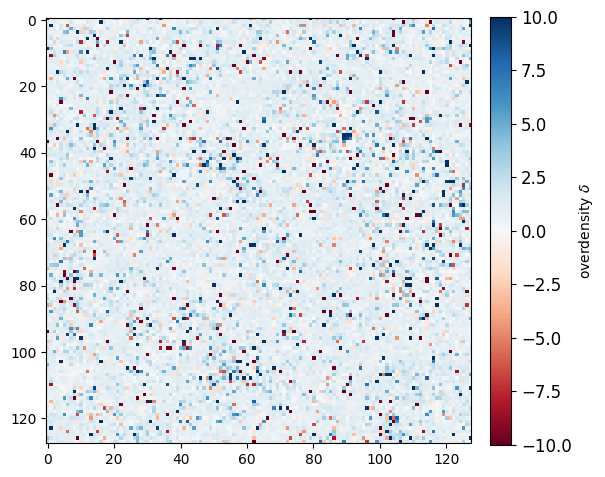

In [36]:
plotter.plot_field(bias_terms_eul_pred_kcut_deconvolved[0] /
                   bias_terms_eul_pred_zspace_kcut_deconvolved[0],
                   vmin=-10, vmax=10)

## b0000

In [5]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

#tag_params = '_p3_n500'
tag_params = '_p5_n10000'
tag_mocks = tag_params
tag_fields = '_deconvolved'
#dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'
#dir_mocks = f'/data/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[0,0,0,0]'
tag_pk = '_b0000'
tag_pk_zspace = '_b0000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()

# idxs_LH = np.sort([int(re.search(r'LH(\d+)', dir_mocks).group(1)) \
#         for dir_mocks in os.listdir(dir_mocks) \
#         if re.search(r'LH\d+', dir_mocks)])
# idxs_LH = np.sort([int(re.search(r'_(\d+)', dir_pks_zspace).group(1)) \
#         for dir_pks_zspace in os.listdir(dir_pks_zspace) \
#         if re.search(r'_\d+', dir_pks_zspace)])
#idxs_LH = list(params_df.index.values)
# this one gets only ones we've computed pk of (zspace, cuz probs have both if have zspace)
idxs_LH_all = np.array([int(re.search(r'pk_(\d+)\.npy', f).group(1)) for f in glob.glob(f'{dir_pks_zspace}/pk_*.npy')])
idxs_LH_all = np.sort(idxs_LH_all)
# limit to n_plot for now
n_plot = 100
#idxs_LH = idxs_LH_all[:n_plot]
rng = np.random.default_rng(42)
idxs_LH = rng.choice(idxs_LH_all, n_plot, replace=False)

idxs_LH = np.array(np.sort(idxs_LH))
n_lib = len(idxs_LH)

print(n_lib)

100


In [6]:
print(idxs_LH)

[ 266  385  410  461  518  537  558  568  593  769  787  854  940  982
 1003 1108 1158 1185 1217 1376 1384 1467 1686 1774 1917 1990 2020 2162
 2221 2241 2250 2265 2386 2455 2523 2631 2665 2681 2689 2703 2724 2740
 2745 2838 2852 2876 2916 3038 3039 3115 3193 3318 3341 3376 3470 3967
 3995 4051 4061 4127 4401 4460 4542 4591 4603 4643 4732 4782 4848 4971
 5050 5060 5121 5124 5142 5187 5218 5250 5269 5370 5441 5495 5532 5591
 5603 5606 5667 5693 5718 5891 5933 6005 6024 6110 6120 6244 6388 6392
 6393 6672]


### Load data 

In [7]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(100, 30)


In [8]:
# overall quantities
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 100 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    param_dict.update(param_dict_fixed)
    cosmo_params_emu = utils.get_cosmo_emu(param_dict)
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)
print(Pk_emu.shape)

0


(100, 30)


In [9]:
expfactor = 1.0
kaiser_boosts = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 100 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    cosmo = utils.get_cosmo(param_dict)
    # kaiser boost only depends on k if neutrino mass is nonzero
    # for kaiser boost, the bias is the linear EULERIAN bias!
    # which is b1_eul = 1 + b1_lag
    bias_eulerian = 1 + bias_params[0]
    kaiser_boosts.append( cosmo.Kaiser_boost(expfactor, l=0, bias=bias_eulerian) )

0


In [10]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

In [11]:
print(np.min(kaiser_boosts), np.max(kaiser_boosts))

1.3340150075431338 1.4734757784445827


## Plot

/tmp/ipykernel_510374/495678036.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_510374/495678036.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_510374/495678036.py:46: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_510374/495678036.py:51: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7fc46462c190>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x7fc4645b6190>, <matplotlib.lines.Line2D object at 0x7fc464228750>] ['median', '16-84 percentile']


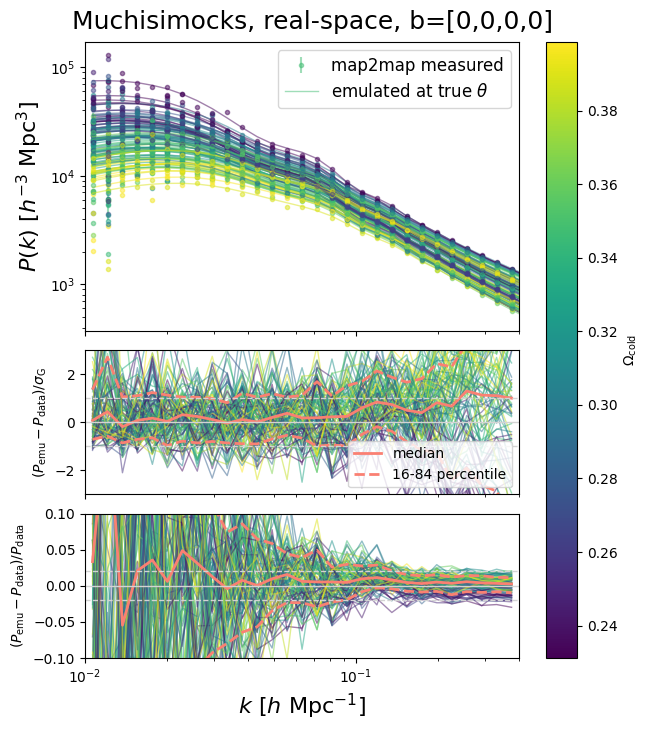

In [12]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
    #axarr[1].set_ylim(-10, 20)
    #axarr[2].set_ylim(-0.4, 0.4)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_510374/1192163480.py:46: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_510374/1192163480.py:47: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_510374/1192163480.py:57: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/tmp/ipykernel_510374/1192163480.py:67: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x7fc43c4b5ad0>, <matplotlib.lines.Line2D object at 0x7fc43c4f7950>, <matplotlib.lines.Line2D object at 0x7fc43c306a10>, <matplotlib.lines.Line2D object at 0x7fc43c3072d0>, <matplotlib.lines.Line2D object at 0x7fc43c319490>, <matplotlib.lines.Line2D object at 0x7fc43c319cd0>, <matplotlib.lines.Line2D object at 0x7fc43c31be90>, <matplotlib.lines.Line2D object at 0x7fc43c3286d0>, <matplotlib.lines.Line2D object at 0x7fc43c32a910>, <matplotlib.lines.Line2D object at 0x7fc43c32b110>, <matplotlib.lines.Line2D object at 0x7fc43c339310>, <matplotlib.lines.Line2D object at 0x7fc43c339b90>, <matplotlib.lines.Line2D object at 0x7fc43c33bd50>, <matplotlib.lines.Line2D object at 0x7fc43c3444d0>, <matplotlib.lines.Line2D object at 0x7fc43c3467d0>, <matplotlib.lines.Line2D object at 0x7fc43c346fd0>, <matplotlib.lines.Line2D object at 0x7fc43c355250>, <matplotlib.lines.Line2D object at 0x7fc43c355a50>, <matplotlib.lines.Line2D object at 0x7fc43c357b10>, <matplotlib

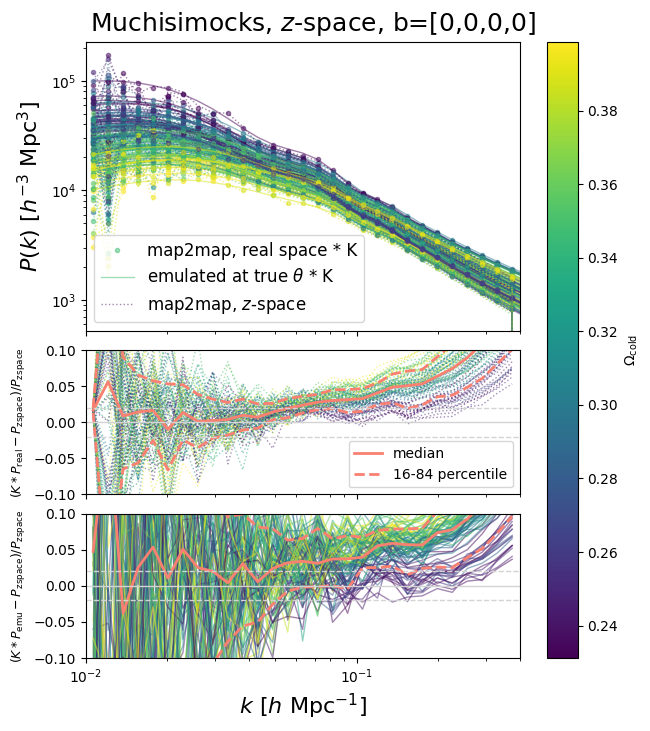

In [13]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_510374/2375682257.py:45: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_510374/2375682257.py:52: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7fc41c390d10>, <matplotlib.lines.Line2D object at 0x7fc41c2d8710>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x7fc43c537110>, <matplotlib.lines.Line2D object at 0x7fc3fc63d590>] ['median', '16-84 percentile']


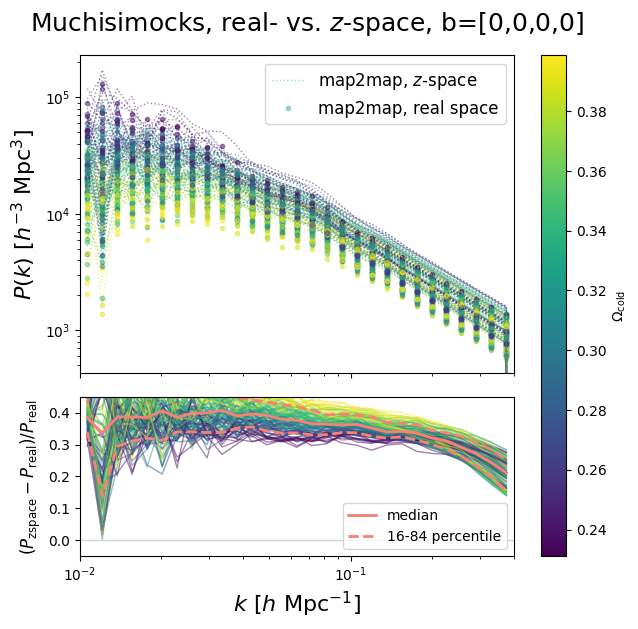

In [14]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.45)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')